In [1]:
from pyfaidx import Fasta
import vcf
import re
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # so we can edit the text in resulting figures

In [2]:
hg38 = Fasta("hg38/genome.fa")

In [3]:
clinvar = vcf.Reader(open("clinvar_20180225.vcf","r"))
seenVariants = {}
good_TtoC_variants = []
good_AtoG_variants = []
ignoredCLNSIG = {}
ignoredCLNVC = {}
good_line_refs = {}
good_line_count = 0 #pathogenic and SNV
good_AtoG_count = 0 #pathogenic SNV A->G
good_TtoC_count = 0 #pathogenic SNV T->C
other_line_count = 0 #duplicates, nonpathogenic, nonSNV
bad_line_count = 0 #couldn't read header
dupCount = 0 #duplicated

for record in clinvar:
    if 'CLNVC' not in record.INFO or 'CLNSIG' not in record.INFO or 'RS' not in record.INFO:
        bad_line_count += 1
        continue  
    if record.INFO['CLNVC'] != "single_nucleotide_variant":
        if record.INFO['CLNVC'] not in ignoredCLNVC:
            ignoredCLNVC[record.INFO['CLNVC']] = 0
        ignoredCLNVC[record.INFO['CLNVC']] += 1
        other_line_count += 1
        continue
    if "Pathogenic" not in str(record.INFO['CLNSIG']):
        if str(record.INFO['CLNSIG']) not in ignoredCLNSIG:
            ignoredCLNSIG[str(record.INFO['CLNSIG'])] = 0
        ignoredCLNSIG[str(record.INFO['CLNSIG'])] += 1
        other_line_count += 1
        continue
    if str(record.INFO['RS']) in seenVariants:
        dupCount += 1
        continue
    else:
        seenVariants[str(record.INFO['RS'])] = 1
    good_line_count += 1
    
    key = record.REF + ">" + str(record.ALT[0])
    if key not in good_line_refs:
        good_line_refs[key] = 0
    good_line_refs[key] += 1

    if 'A' == record.REF and 'G' in record.ALT:
        good_AtoG_variants.append(record)
        good_AtoG_count += 1
    elif 'T' == record.REF and 'C' in record.ALT:
        good_TtoC_variants.append(record)
        good_TtoC_count += 1

        

print('ignoring ' + str(bad_line_count) + ' unparsable lines')
print('ignoring ' + str(other_line_count) + ' nonpathogenic/nonSNV lines')
print('ignoring ' + str(dupCount) + ' duplicates')
print('got ' + str(good_line_count) + ' good lines')
print('got ' + str(good_AtoG_count) + ' A>G lines')
print('got ' + str(good_TtoC_count) + ' T>C lines')


ignoring 26013 unparsable lines
ignoring 286288 nonpathogenic/nonSNV lines
ignoring 1747 duplicates
got 32045 good lines
got 2289 A>G lines
got 2288 T>C lines


In [4]:
print(record.INFO['CLNVC'])

single_nucleotide_variant


In [5]:
print(ignoredCLNVC)

{'Inversion': 23, 'Deletion': 21993, 'Microsatellite': 14, 'Variation': 1, 'Indel': 2003, 'Insertion': 2286, 'Duplication': 8325}


In [6]:
str(record.INFO)

"{'CLNREVSTAT': ['no_assertion_criteria_provided'], 'ORIGIN': ['1'], 'RS': ['199474699'], 'CLNSIG': ['Pathogenic'], 'GENEINFO': 'MT-TP:4571', 'ALLELEID': 24609, 'CLNVI': ['OMIM_Allelic_Variant:590075.0001'], 'CLNVC': 'single_nucleotide_variant', 'CLNHGVS': ['NC_012920.1:m.15990C>T'], 'CLNDISDB': ['MedGen:C0026848'], 'CLNVCSO': 'SO:0001483', 'CLNDN': ['Myopathy']}"

In [7]:
good_line_refs

{'A>C': 1010,
 'A>G': 2289,
 'A>None': 1,
 'A>T': 1011,
 'C>A': 2398,
 'C>G': 1597,
 'C>None': 2,
 'C>T': 7414,
 'CCTGTTGAAGTGGTGCCCGAGGTGCCCATTGGCTGACTGTTCATGTGTGTCTGCATATGTGGGGGGGTGTAGGTATCATAACTCCGCCCATTCACCGAAGGGCTGGTGGGCAGCATGCAGGAGTATGAGGAGGTCTGGCTGGGGACTGGGGG>C': 1,
 'G>A': 8272,
 'G>C': 1547,
 'G>N': 2,
 'G>T': 2137,
 'T>A': 1156,
 'T>C': 2288,
 'T>G': 917,
 'T>None': 3}

In [8]:
[str(x) for x in good_TtoC_variants[1:5]]

['Record(CHROM=1, POS=1806509, REF=T, ALT=[C])',
 'Record(CHROM=1, POS=1806515, REF=T, ALT=[C])',
 'Record(CHROM=1, POS=2412502, REF=T, ALT=[C])',
 'Record(CHROM=1, POS=3414616, REF=T, ALT=[C])']

In [9]:
[str(x) for x in good_AtoG_variants[1:5]]

['Record(CHROM=1, POS=1232471, REF=A, ALT=[G])',
 'Record(CHROM=1, POS=1804565, REF=A, ALT=[G])',
 'Record(CHROM=1, POS=2406566, REF=A, ALT=[G])',
 'Record(CHROM=1, POS=2412501, REF=A, ALT=[G])']

In [10]:
chr_lookup = {'MT':'chrM','X':'chrX','Y':'chrY'}
for i in range(23):
    chr_lookup[str(i)] = 'chr' + str(i)

In [11]:
# Example 1: v
#           ATCCTGCGAGGCACTGACGAGA <= genomic sequence (T->C SNP is the first T)
#        MMMMXXXXXMMMMMMMMMMMPAM   <= editing window of guide where SNP is left-most
#    MMMMXXXXXMMMMMMMMMMMPAM       <= editing window of guide where SNP is right->most
#                        CTGACGA   <= PAM search range (+11 to +18)


#Example 2: v
#          ATGGCCGCGGGTTCGGGTGGTC
#       MMMMXXXXXMMMMMMMMMMMPAM
#   MMMMXXXXXMMMMMMMMMMMPAM
#                       CGGGTGG   <= PAM search range (+11 to +18)


hits = []

#pams = (r'(?=[ACTG]GG)',r'(?=[ACTG]GA)') #NGG, NGA
pams = [r'(?=[ACTG]G[GAT])'] #NGG, NGA, NGT
#range: +12 to +16 to the pam, so we look for the pam (NGG or NGA) from +12 to +18 (3 for the PAM minus 1 for the offset)
#for record in good_TtoC_variants[1:5]:
for record in good_TtoC_variants:
    snp_pos = record.POS
    pam_search_str = str(hg38[chr_lookup[record.CHROM]][snp_pos+11:snp_pos+18]).upper()
    five_prime_base = str(hg38[chr_lookup[record.CHROM]][snp_pos-2]).upper()
    genomic_context = str(hg38[chr_lookup[record.CHROM]][snp_pos-6:snp_pos+5]).upper()
    contains_pam=False
    for pam in pams:
        #print('searching for pam ' + pam + ' in search ' + pam_search_str)
        for m in re.finditer(pam,pam_search_str):
            contains_pam=True
            pam_start = m.start(0) + snp_pos + 11
            pam_str = str(hg38[chr_lookup[record.CHROM]][pam_start:pam_start+3]).upper()
            #print('pam :' + pam_str)
            guide_start = m.start(0) + snp_pos + 11 - 20
            guide_end = m.start(0) + 3 + snp_pos + 11
            #print('guide : ' + str(guide_start) + ' to '+str(guide_end))
            guide_str = str(hg38[chr_lookup[record.CHROM]][guide_start:guide_end]).upper()
            #the guide will be designed for the mutant -- This base is now a C
            guide_str = guide_str[:snp_pos-guide_start-1] + 'C' + guide_str[snp_pos-guide_start:]
            editing_window = guide_str[4:9]
            #print('guide str: ' + guide_str)
            #print('editing window:' + editing_window)
            num_cs_in_editing_window = editing_window.count('C')
            #print('num cs: ' + str(num_cs_in_editing_window))
            
            #bystander window (count number of XC's in the editing window)
            bystander_AC_count = 0
            bystander_TC_count = 0
            bystander_CC_count = 0
            bystander_GC_count = 0
            bystander_NC_count = 0
            
            for i in range(4,9):
                if guide_start + i + 1 == snp_pos:
                    continue
                elif guide_str[i] == 'C':
                    if guide_str[i-1] == 'A':
                        bystander_AC_count += 1
                    elif guide_str[i-1] == 'T':
                        bystander_TC_count += 1
                    elif guide_str[i-1] == 'C':
                        bystander_CC_count += 1
                    elif guide_str[i-1] == 'G':
                        bystander_GC_count += 1
                    elif guide_str[i-1] == 'N':
                        bystander_NC_count += 1

            
            hits.append([record.CHROM,record.POS,record.INFO['CLNDN'],record.INFO,record.REF,record.ALT,genomic_context,pam_start,pam_str,guide_start,guide_str,
                         five_prime_base,editing_window,num_cs_in_editing_window,
                         bystander_AC_count,bystander_TC_count,bystander_CC_count,bystander_GC_count,bystander_NC_count,
                         'FW'])

    #debug to print information above
    debug = False
    if debug:
        print('---')
        print(record)
        print('whole seq: ' + str(hg38[chr_lookup[record.CHROM]][snp_pos-2:snp_pos+20]))
        print('5 prime base:' + five_prime_base)
        print(pam_search_str)  
        print('contains: ' + str(contains_pam))



In [12]:
hits[0:5]

[['1',
  1806509,
  ['Strabismus|Seizures|Muscular_hypotonia|Global_developmental_delay|Growth_delay|Infantile_muscular_hypotonia|EEG_with_generalized_epileptiform_discharges|Feeding_difficulties|Mental_retardation',
   '_autosomal_dominant_42|not_provided'],
  {'ALLELEID': 226499,
   'CLNDISDB': ['Human_Phenotype_Ontology:HP:0000486',
    'MedGen:C0038379|Human_Phenotype_Ontology:HP:0001250',
    'MedGen:C0036572|Human_Phenotype_Ontology:HP:0001252',
    'MedGen:CN001147|Human_Phenotype_Ontology:HP:0001263',
    'MedGen:C4020875|Human_Phenotype_Ontology:HP:0001510',
    'MedGen:C3552463|Human_Phenotype_Ontology:HP:0008947',
    'MedGen:C1860834|Human_Phenotype_Ontology:HP:0011198',
    'MedGen:C4023476|Human_Phenotype_Ontology:HP:0011968',
    'MedGen:C0232466|MedGen:C4310774',
    'OMIM:616973|MedGen:CN517202'],
   'CLNDN': ['Strabismus|Seizures|Muscular_hypotonia|Global_developmental_delay|Growth_delay|Infantile_muscular_hypotonia|EEG_with_generalized_epileptiform_discharges|Feeding

In [13]:
# Example 1:          v
#  CCTGGCAGTGCTGGTGGCCAGC       <= genomic sequence (A->G SNP is the last A)
#       PAMMMMMMMMMMMMXXXXXMMMM <= editing window of guide where SNP is left-most
#   PAMMMMMMMMMMMMXXXXXMMMM     <= editing window of guide where SNP is right->most     
#   CTGGCAG                     <= PAM search range (-19 to -12)

# Example 2:         v
# CATGACCCAGGAGGAGCGCAGA         <= genomic sequence (A->G SNP is the 2nd to last A)
#      PAMMMMMMMMMMMMXXXXXMMMM   <= editing window of guide where SNP is left-most
#  PAMMMMMMMMMMMMXXXXXMMMM       <= editing window of guide where SNP is right->most     
#  ATGACCC                       <= PAM search range (-19 to -12)

#
rc_hits = []

complement = {'A':'T','C':'G','G':'C','T':'A','N':'N'}
#pams = (r'(?=[ACTG]GG)',r'(?=[ACTG]GA)') #NGG, NGA
#pams = [r'(?=[ACTG]G[GAT])'] #NGG, NGA, NGT
pams = [r'(?=[ACT]C[ACGT])'] #NGG, NGA, NGT (rc: CCN TCN ACN)
#for record in good_AtoG_variants[1:10]:
for record in good_AtoG_variants:
    snp_pos = record.POS
    pam_search_str = str(hg38[chr_lookup[record.CHROM]][snp_pos-19:snp_pos-12]).upper()
    five_prime_base = complement[str(hg38[chr_lookup[record.CHROM]][snp_pos]).upper()]
    genomic_context = str(hg38[chr_lookup[record.CHROM]][snp_pos-6:snp_pos+5]).upper()
    contains_pam=False
    for pam in pams:
        #print('searching for pam ' + pam + ' in search ' + pam_search_str)
        for m in re.finditer(pam,pam_search_str):
            contains_pam=True
            pam_start = m.start(0) + snp_pos - 19
            pam_str_rc = str(hg38[chr_lookup[record.CHROM]][pam_start+0:pam_start+3]).upper()
            pam_str = "".join([complement[c] for c in pam_str_rc.upper()[-1::-1]])
            guide_start = m.start(0) + snp_pos - 19 
            guide_end = m.start(0) + 3 + snp_pos - 19 + 20
            #print('guide : ' + str(guide_start) + ' to '+str(guide_end))
            guide_str_rc = str(hg38[chr_lookup[record.CHROM]][guide_start:guide_end]).upper()
            #the guide will be designed for the mutant -- This base is now a G
            guide_str_rc = guide_str_rc[:snp_pos-guide_start-1] + 'G' + guide_str_rc[snp_pos-guide_start:]
            
            guide_str = "".join([complement[c] for c in guide_str_rc.upper()[-1::-1]])
            editing_window = guide_str[4:9]
            #print('guide str: ' + guide_str)
            #print('editing window:' + editing_window)
            num_cs_in_editing_window = editing_window.count('C')
            #print('num cs: ' + str(num_cs_in_editing_window))
            
            #bystander window (count number of XC's in the editing window)
            bystander_AC_count = 0
            bystander_TC_count = 0
            bystander_CC_count = 0
            bystander_GC_count = 0
            bystander_NC_count = 0
            
            for i in range(4,9):
                if guide_start + len(guide_str) - i == snp_pos:
                    continue
                elif guide_str[i] == 'C':
                    if guide_str[i-1] == 'A':
                        bystander_AC_count += 1
                    elif guide_str[i-1] == 'T':
                        bystander_TC_count += 1
                    elif guide_str[i-1] == 'C':
                        bystander_CC_count += 1
                    elif guide_str[i-1] == 'G':
                        bystander_GC_count += 1
                    elif guide_str[i-1] == 'N':
                        bystander_NC_count += 1
                        

            rc_hits.append([record.CHROM,record.POS,record.INFO['CLNDN'],record.INFO,record.REF,record.ALT,genomic_context,pam_start,pam_str,guide_start,guide_str,
                            five_prime_base,editing_window,num_cs_in_editing_window,
                            bystander_AC_count,bystander_TC_count,bystander_CC_count,bystander_GC_count,bystander_NC_count,
                            'RC'])

    #debug to print information above
    debug = False
    if debug:
        print('---')
        print(record)
        print('whole seq: ' + str(hg38[chr_lookup[record.CHROM]][snp_pos-2:snp_pos+20]))
        print('5 prime base:' + five_prime_base)
        print(pam_search_str)  
        print('contains: ' + str(contains_pam))

In [14]:
rc_hits[0:3]

[['1',
  1232279,
  ['Spondyloepimetaphyseal_dysplasia_with_joint_laxity'],
  {'ALLELEID': 75079,
   'CLNDISDB': ['MedGen:C0432243',
    'OMIM:271640',
    'Orphanet:ORPHA93359',
    'SNOMED_CT:254100000'],
   'CLNDN': ['Spondyloepimetaphyseal_dysplasia_with_joint_laxity'],
   'CLNHGVS': ['NC_000001.11:g.1232279A>G'],
   'CLNREVSTAT': ['no_assertion_criteria_provided'],
   'CLNSIG': ['Pathogenic'],
   'CLNVC': 'single_nucleotide_variant',
   'CLNVCSO': 'SO:0001483',
   'CLNVI': ['OMIM_Allelic_Variant:615291.0001'],
   'GENEINFO': 'B3GALT6:126792',
   'MC': ['SO:0001583|missense_variant'],
   'ORIGIN': ['1'],
   'RS': ['786200938']},
  'A',
  [G],
  'GCGCCATGAAG',
  1232263,
  'GGG',
  1232263,
  'AGCTTCACGGCGCCCGCGCCGGG',
  'A',
  'TCACG',
  2,
  0,
  1,
  0,
  0,
  0,
  'RC'],
 ['1',
  1232279,
  ['Spondyloepimetaphyseal_dysplasia_with_joint_laxity'],
  {'ALLELEID': 75079,
   'CLNDISDB': ['MedGen:C0432243',
    'OMIM:271640',
    'Orphanet:ORPHA93359',
    'SNOMED_CT:254100000'],
   '

In [15]:
col_names = ['chr','pos','CLNDN','info','ref','alt','genomic_context','pam_start','pam','guide_start','guide','five_prime_base',
             'editing_window','num_cs_in_editing_window',
             'bystander_AC_count','bystander_TC_count','bystander_CC_count','bystander_GC_count','bystander_NC_count',
             'orientation']
with open ('getClinvar.out.txt','w') as outfile:
    outfile.write("\t".join(col_names) + '\n')
    for hit in hits:
        outfile.write("\t".join([str(x) for x in hit]) + "\n")
    for hit in rc_hits:
        outfile.write("\t".join([str(x) for x in hit]) + "\n")

In [16]:
all_hits = []
all_hits.extend(hits)
all_hits.extend(rc_hits)
df = pd.DataFrame.from_records(all_hits,columns = col_names)
print('fw hits: ' + str(len(hits)))
print('rv hits: ' + str(len(rc_hits)))
print('all: ' + str(len(all_hits)))



fw hits: 2314
rv hits: 2381
all: 4695


In [17]:
df

,chr,pos,CLNDN,info,ref,alt,genomic_context,pam_start,pam,guide_start,guide,five_prime_base,editing_window,num_cs_in_editing_window,bystander_AC_count,bystander_TC_count,bystander_CC_count,bystander_GC_count,bystander_NC_count,orientation
0,1,1806509,[Strabismus|Seizures|Muscular_hypotonia|Global...,"{u'CLNREVSTAT': [u'criteria_provided', u'_sing...",T,[C],TAAGTTTACCA,1806521,AGG,1806501,GATAAGTCTACCATCCTGCGAGG,T,AGTCT,1,0,0,0,0,0,FW
1,1,1806515,[Acute_lymphoid_leukemia|Intellectual_disabili...,{u'CLNREVSTAT': [u'no_assertion_criteria_provi...,T,[C],TACCATCCTGC,1806527,TGA,1806507,TTTACCACCCTGCGAGGCACTGA,A,CCACC,4,1,0,2,0,0,FW
2,1,1806515,[Acute_lymphoid_leukemia|Intellectual_disabili...,{u'CLNREVSTAT': [u'no_assertion_criteria_provi...,T,[C],TACCATCCTGC,1806530,CGA,1806510,ACCACCCTGCGAGGCACTGACGA,A,CCCTG,3,0,0,2,0,0,FW
3,1,2412502,[not_provided],"{u'CLNREVSTAT': [u'criteria_provided', u'_sing...",T,[C],GGCCATGGCCG,2412513,CGG,2412493,CGGGGCCACGGCCGCGGGTTCGG,A,GCCAC,3,0,0,1,1,0,FW
4,1,2412502,[not_provided],"{u'CLNREVSTAT': [u'criteria_provided', u'_sing...",T,[C],GGCCATGGCCG,2412514,GGG,2412494,GGGGCCACGGCCGCGGGTTCGGG,A,CCACG,3,0,0,1,1,0,FW
5,1,2412502,[not_provided],"{u'CLNREVSTAT': [u'criteria_provided', u'_sing...",T,[C],GGCCATGGCCG,2412515,GGT,2412495,GGGCCACGGCCGCGGGTTCGGGT,A,CACGG,2,0,0,1,0,0,FW
6,1,2412502,[not_provided],"{u'CLNREVSTAT': [u'criteria_provided', u'_sing...",T,[C],GGCCATGGCCG,2412517,TGG,2412497,GCCACGGCCGCGGGTTCGGGTGG,A,CGGCC,3,0,0,1,1,0,FW
7,1,9719924,[Immunodeficiency_14],{u'CLNREVSTAT': [u'no_assertion_criteria_provi...,T,[C],AGGACTGCCCC,9719935,TGG,9719915,TGCAGGACCGCCCCATTGCCTGG,C,GGACC,2,1,0,0,0,0,FW
8,1,9719924,[Immunodeficiency_14],{u'CLNREVSTAT': [u'no_assertion_criteria_provi...,T,[C],AGGACTGCCCC,9719936,GGG,9719916,GCAGGACCGCCCCATTGCCTGGG,C,GACCG,2,1,0,0,0,0,FW
9,1,9982577,[Leber_congenital_amaurosis_9],"{u'CLNREVSTAT': [u'criteria_provided', u'_sing...",T,[C],CTACTTGGTAC,9982589,TGT,9982569,CGCTACTCGGTACCAGATCTTGT,T,ACTCG,2,1,0,0,0,0,FW


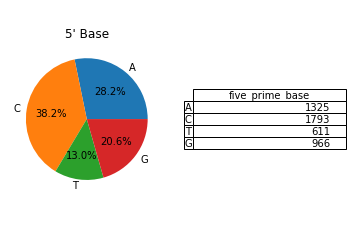

In [18]:
tab = df['five_prime_base'].value_counts().reindex(['A','C','T','G'])
ax1 = plt.subplot(121,aspect='equal')
tab.plot(kind='pie',title="5' Base", autopct='%1.1f%%',ax=ax1)
ax1.yaxis.set_label_text('')

ax2 = plt.subplot(122)
plt.axis('off')
tbl = table(ax2,tab,loc='center')

### Filter guides that target the same SNP -- select the guide with the lowest number of bystander C's

In [19]:
filtered = df.sort_values("num_cs_in_editing_window",ascending=True).groupby("pos",as_index=False).first()

In [20]:
filtered

,pos,chr,CLNDN,info,ref,alt,genomic_context,pam_start,pam,guide_start,guide,five_prime_base,editing_window,num_cs_in_editing_window,bystander_AC_count,bystander_TC_count,bystander_CC_count,bystander_GC_count,bystander_NC_count,orientation
0,608,MT,"[Nephropathy, _tubulointerstitial]",{u'CLNREVSTAT': [u'no_assertion_criteria_provi...,A,[G],AATACACTGAA,590,AGG,590,TTCAGCGTATTGCTTTGAGGAGG,G,GCGTA,1,0,0,0,0,0,RC
1,3260,MT,[Cardiomyopathy_with_or_without_skeletal_myopa...,{u'CLNREVSTAT': [u'no_assertion_criteria_provi...,A,[G],GCATAAAACTT,3245,CGG,3245,TTTAAGTTCTATGCGATTACCGG,T,AGTTC,1,0,0,0,0,0,RC
2,3271,MT,"[Juvenile_myopathy, _encephalopathy, _lactic_a...","{u'CLNREVSTAT': [u'criteria_provided', u'_sing...",T,[C],AAAACTTTACA,3282,GGT,3262,CTTAAAACCTTACAGTCAGAGGT,C,AAACC,2,1,0,0,0,0,FW
3,3796,MT,"[Dystonia, _adult-onset]",{u'CLNREVSTAT': [u'no_assertion_criteria_provi...,A,[G],TCTCCACCCTT,3781,AGG,3781,GATAAGGGCGGAGAGGTTAAAGG,G,AGGGC,1,0,0,0,0,0,RC
4,4160,MT,[Leber's_optic_atrophy],{u'CLNREVSTAT': [u'no_assertion_criteria_provi...,T,[C],CCAACTCATAC,4173,TGA,4153,ACCAACCCATACACCTCCTATGA,C,ACCCA,3,1,0,1,0,0,FW
5,4269,MT,"[Cardiomyopathy, _fatal]",{u'CLNREVSTAT': [u'no_assertion_criteria_provi...,A,[G],GAAATATGTCT,4251,AGG,4251,AGACACATTTCTTAGGTTTGAGG,A,ACATT,1,0,0,0,0,0,RC
6,4291,MT,"[Hypertension, _hypercholesterolemia, _and_hyp...",{u'CLNREVSTAT': [u'no_assertion_criteria_provi...,T,[C],TACTTTGATAG,4306,AGG,4286,ACTTCGATAGAGTAAATAATAGG,T,CGATA,1,0,0,0,0,0,FW
7,5559,MT,[Leigh_syndrome],{u'CLNREVSTAT': [u'no_assertion_criteria_provi...,A,[G],CAGTAAGTTGC,5543,TGA,5543,TTGCAACCTACTGAGGGCTTTGA,C,AACCT,2,1,0,0,0,0,RC
8,5728,MT,[Cytochrome-c_oxidase_deficiency|Mitochondrial...,{u'CLNREVSTAT': [u'no_assertion_criteria_provi...,T,[C],CAATCTACTTC,5743,GGG,5723,AATCCACTTCTCCCGCCGCCGGG,C,CACTT,2,1,0,0,0,0,FW
9,5816,MT,"[Dystonia, _mitochondrial]",{u'CLNREVSTAT': [u'no_assertion_criteria_provi...,A,[G],AAATCACCTCG,5801,TGA,5801,CTCCGAGGCGATTTTCATATTGA,G,GAGGC,1,0,0,0,0,0,RC


### Show distribution of 5' base

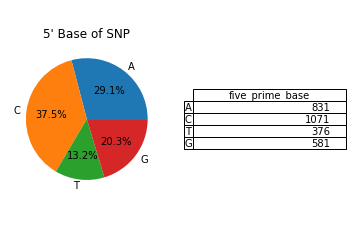

In [21]:
tab = filtered['five_prime_base'].value_counts().reindex(['A','C','T','G'])
ax1 = plt.subplot(121,aspect='equal')
tab.plot(kind='pie',title="5' Base of SNP", autopct='%1.1f%%',ax=ax1)
ax1.yaxis.set_label_text('')

ax2 = plt.subplot(122)
plt.axis('off')
tbl = table(ax2,tab,loc='center')
plt.savefig('five_prime_base.pdf')

### Select SNPs with 5' T
Of SNPs with 5' T, how many C's are in the editing window?

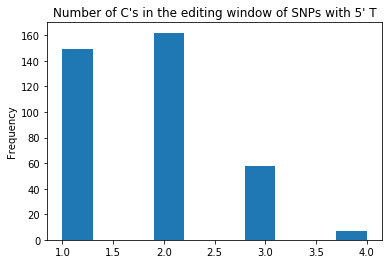

In [22]:
snps_with_5prime_t = filtered[filtered.five_prime_base == 'T']
snps_with_5prime_t.num_cs_in_editing_window.plot(kind='hist',title="Number of C's in the editing window of SNPs with 5' T")

In [23]:
snps_with_5prime_t['num_cs_in_editing_window'].value_counts(sort=False)

1    149
2    162
3     58
4      7
Name: num_cs_in_editing_window, dtype: int64

In [24]:
snps_w_multi_Cs = snps_with_5prime_t[snps_with_5prime_t.num_cs_in_editing_window> 1]

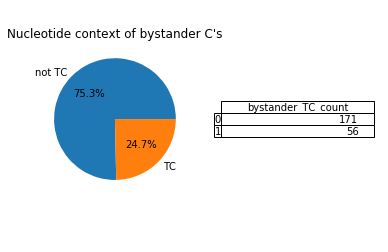

In [25]:
tab = snps_w_multi_Cs['bystander_TC_count'].value_counts()
ax1 = plt.subplot(121,aspect='equal')
tab.plot(kind='pie',title="Nucleotide context of bystander C's", autopct='%1.1f%%',ax=ax1,labels=['not TC','TC'])
ax1.yaxis.set_label_text('')


ax2 = plt.subplot(122)
plt.axis('off')
tbl = table(ax2,tab,loc='center')
plt.savefig('bystander_TC.pdf')

In [28]:
bystander_not_TC = snps_w_multi_Cs[snps_w_multi_Cs.bystander_TC_count == 0]
bystander_not_TC.to_csv('bystander_not_TC.txt',sep="\t",index=False)